<a href="https://colab.research.google.com/github/kazzand/nvideagans/blob/master/Kaznacheev_Andrey_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.autograd import Variable

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
class generator(nn.Module):
    def __init__(self, d=32):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(32, d*8, 4, 2, 0)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)
    def forward(self, input):
        x = nn.LeakyReLU()(self.deconv1(input))
        x = nn.LeakyReLU()(self.deconv2(x))
        x = nn.LeakyReLU()(self.deconv3(x))
        x = nn.LeakyReLU()(self.deconv4(x))
        x = nn.LeakyReLU()(self.deconv5(x))
        return x


In [0]:
class discriminator(nn.Module):
    def __init__(self, d=64):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = nn.LeakyReLU()(self.conv1(input))
        x = nn.LeakyReLU()(self.conv2(x))
        x = nn.LeakyReLU()(self.conv3(x))
        x = nn.LeakyReLU()(self.conv4(x))
        x = F.sigmoid(self.conv5(x))

        return x

In [0]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    imgs = imgs.cpu()
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [0]:
# training parameters
batch_size = 128
lr = 0.001
train_epoch = 15


# data_loader
img_size = 64
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [0]:
# network
G = generator()
D = discriminator()

G.cuda()
D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

In [0]:
# Adam optimizers
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Num epoch  14


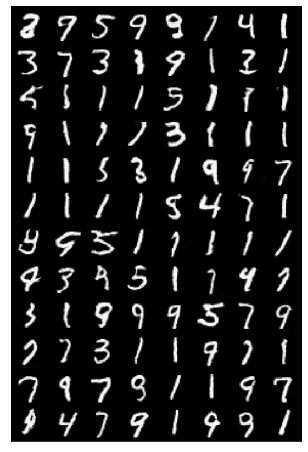

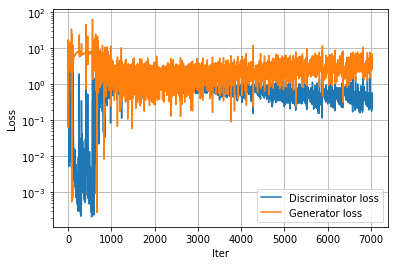

In [0]:
#Training 
D_losses = []
G_losses = []
for epoch in range(train_epoch):
    for x, _ in train_loader:
        # Discriminator step
        D.zero_grad()
        
        mini_batch = x.size()[0]
        
        y_real = torch.ones(mini_batch)
        y_fake = torch.zeros(mini_batch)
        
        x, y_real, y_fake = Variable(x.cuda()), Variable(y_real.cuda()), Variable(y_fake.cuda())
        D_result = D(x).squeeze()
        D_real_loss = BCE_loss(D_result, y_real)
        
        z = torch.randn((mini_batch, 32)).view(-1, 32, 1, 1)
        z = Variable(z.cuda())
        G_result = G(z)
        
        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake)
        D_fake_score = D_result.data.mean()
        
        D_train_loss = D_real_loss + D_fake_loss
        
        D_train_loss.backward()
        D_optimizer.step()
        
        D_losses.append(D_train_loss.item())

        # Generator step
        G.zero_grad()
        
        z = torch.randn((mini_batch, 32)).view(-1, 32, 1, 1)
        z = Variable(z.cuda())
        
        G_result = G(z)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real)
        G_losses.append(G_train_loss.item())
        
        G_train_loss.backward()
        
        G_optimizer.step()

        samples = G_result.detach()
    
    clear_output()
    print("Num epoch ", epoch)
    imshow(samples)
    plt.show()
    plt.semilogy(D_losses, label = "Discriminator loss")
    plt.semilogy(G_losses, label = "Generator loss")
    plt.xlabel("Iter")
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()
        

**Тут кончается ГАН с первого задания и начинается задание номер два(2). Начнем с создания feed-forward модели.**


Общая идея:
Сделаем обучающий датасет, сгенерировав пары *вектор h - картинка* в нашем генераторе и сохраним. На вход модели подается картинка, из которой мы получаем какой-то вектор. Далее считаем лосс между вектором, который выплюнула модель и таргетным вектором h и делаем шаг оптимизатором.

In [0]:
#Create training data
train = []
N = 9984
for i in range(N):
    small_mas = []
    z = torch.randn((1, 32)).view(-1, 32, 1, 1).cuda()
    small_mas.append(z)
    G_res = G(z)
    small_mas.append(G_res)
    train.append(small_mas)

In [0]:
# Dataloader
ff_loader = torch.utils.data.DataLoader(
    train,
    batch_size=64, shuffle=False)

In [0]:
# Model image2vector, some convolutions and fc layer in the end
class FF_model(torch.nn.Module):    
    def __init__(self):
        super(FF_model, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 6,kernel_size = 4, stride = 2, padding = 0)
        
        self.conv2 = torch.nn.Conv2d(in_channels = 6, out_channels = 16,kernel_size = 4, stride = 2, padding = 0)

        self.conv3 = torch.nn.Conv2d(in_channels = 16, out_channels = 24,kernel_size = 4, stride = 2, padding = 0)

        self.conv4 = torch.nn.Conv2d(in_channels = 24, out_channels = 32,kernel_size = 4, stride = 2, padding = 0)
       
        self.fc1   = torch.nn.Linear( 128, 32)
       
    
    def forward(self, x):
        x = nn.LeakyReLU()(self.conv1(x))
        x = nn.LeakyReLU()(self.conv2(x))
        x = nn.LeakyReLU()(self.conv3(x))
        x = nn.LeakyReLU()(self.conv4(x))
        x=nn.Flatten()(x)

        x = self.fc1(x)
       
        
        return x


In [0]:
model = FF_model()
model.cuda()

FF_model(
  (conv1): Conv2d(1, 6, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2))
  (conv4): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=128, out_features=32, bias=True)
)

In [0]:
#using MSE loss, because loss between two vectors, Adam optimizer
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 32, 1, 1])


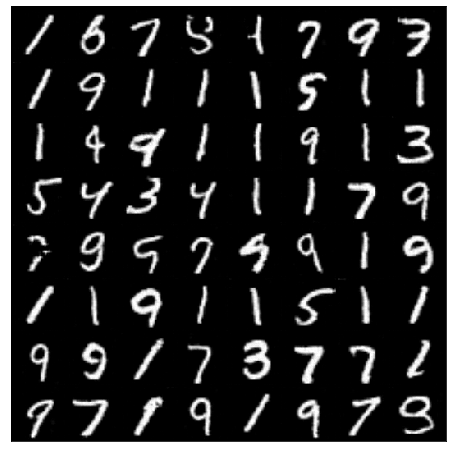

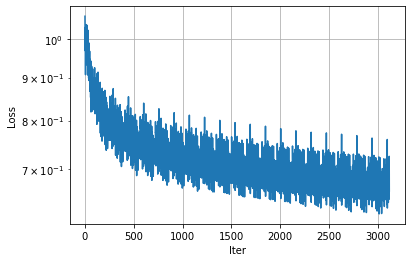

In [0]:
#Training
losses = []
for epoch in range(20):
    for h, img in ff_loader:
       
        model.zero_grad()
        
        #mini_batch = 64
        
        h_true = Variable(h.cuda())
        img = img.squeeze(1)
        img_batch = Variable(img.cuda())
        
        h_true = h_true.squeeze(1)

        preds = model.forward(img_batch)
        preds = preds.view(-1,32,1,1)
        loss_value = loss(preds, h_true)
        loss_value.backward()
        optimizer.step()
        
        losses.append(loss_value.item())
        
    # show results
    clear_output()
    print(preds.shape)
    G_res = G(preds)
    sample = G_res.detach()
    imshow(sample)
    plt.show()
    plt.xlabel("Iter")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.semilogy(losses)
    plt.show()
# 

In [0]:
img_batch.shape

torch.Size([64, 1, 64, 64])

*Проверим, как сработала модель, возьмем картинку из обучающей выборки и сравним с картинкой, полученной из вектора, который выплюнула модель скормленного генератору*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


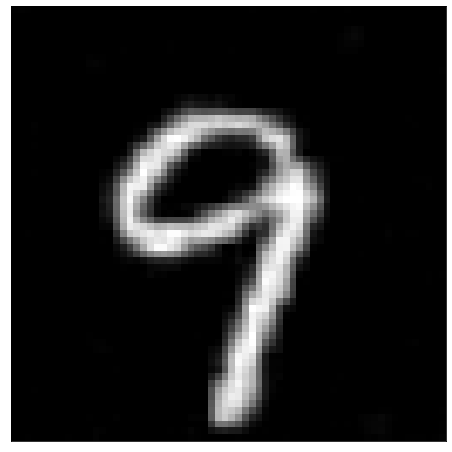

In [0]:
#TRUE IMAGE
d = train[12][1].detach()
imshow(d)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 64, 64])
torch.Size([1, 32])


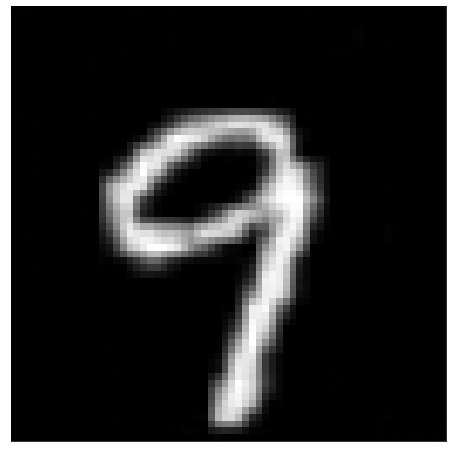

In [0]:
#PRODUCED IMAGE
vec = train[12][1]
print(vec.shape)
pred = model.forward(vec)
print(pred.shape)
pred = pred.view(-1,32,1,1)
#reshape is all you need
#show what we get
G_res = G(pred)
im = G_res.detach()
imshow(im)
plt.show()

*Как видим, модель восстанавливает вектор, из которого генератор разматывает очень даже похожее изображение. Модель работает)*


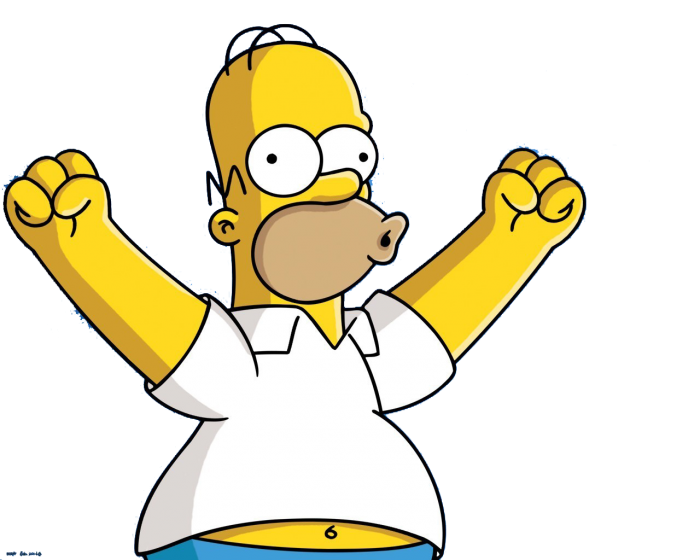



**Теперь приступим ко второй части - оптимизационная модель.**

Общая идея:
Наша модель будет по сути нейронкой-пустышкой, в ней не будет ничего,кроме вектора весов. 
Берем картинку, вектор которой мы хотим получить (можно из мниста), эта картинка будет нашим таргетом. 
Модель выплевывает какой-то вектор, прогоняем этот вектор через генератор и считаем лосс между полученной картинкой и таргетной картинкой. Считаем градиенты, делаем шаг. 



In [0]:
#Create model, init weights, make method to get vector 
class Opt_model(torch.nn.Module):
  def __init__(self):
        super(Opt_model, self).__init__()
        self.vector = torch.nn.Parameter(torch.randn(1,32))
 
  def forward(self):
    x = self.vector
    return x
  

In [0]:
opt_model = Opt_model()
opt_model.cuda()

Opt_model()

In [0]:
#again MSE loss, Adam optimizer
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(opt_model.parameters(), lr=0.1)

torch.Size([1, 64, 64])


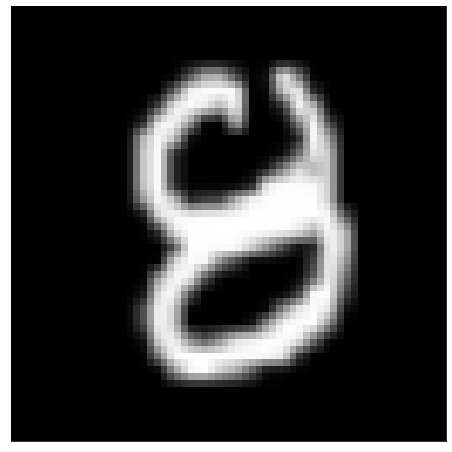

In [0]:
#take from MNIST one image, let's watch this
img_true = next(iter(train_loader))
img_true = img_true[0][2]
print(img_true.shape)
img_true = img_true.view(1,1,64,64)
imshow(img_true)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 64, 64])


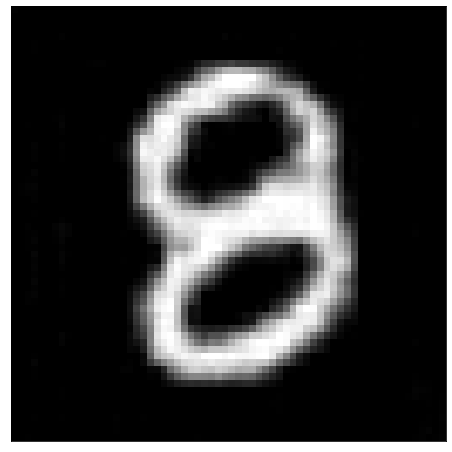

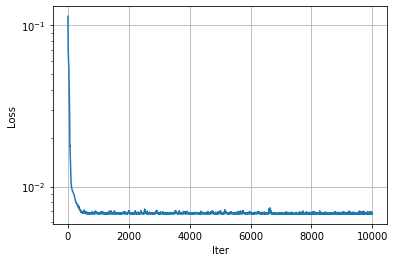

In [0]:
#start training
losses_1 = []
img_true = Variable(img_true.cuda())
for epoch in range(10):
    for i in range(1000):
       
        opt_model.zero_grad()
        

        preds = opt_model()

        preds = preds.view(-1,32,1,1)
        G_pred = G(preds)

        loss_value = loss(G_pred, img_true)

        loss_value.backward()
        optimizer.step()

        losses_1.append(loss_value.item())

    
    clear_output()
    print(G_pred.shape)
    G_res = G(preds)
    sample = G_res.detach()

    imshow(sample)
    plt.xlabel("Iter")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.semilogy(losses_1)
    plt.show()

Как видим, эта модель так же неплохо восстанавливает вектор h, из которого генератор делает практически такое же изображение.

Время экспериментов, интересно посмотреть, что он сможет восстановить из суммы разных цифр.

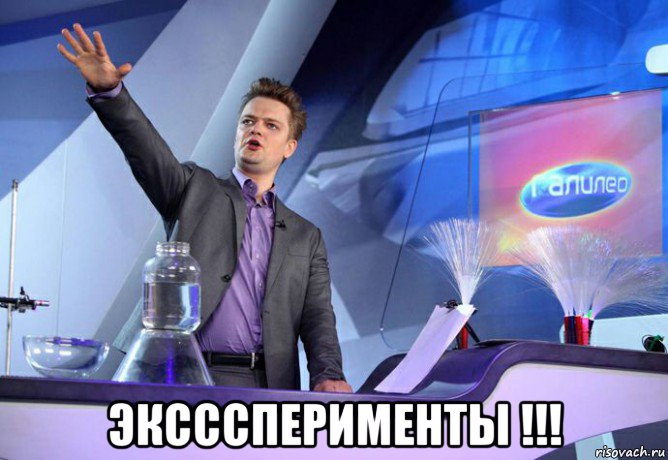

torch.Size([1, 64, 64])


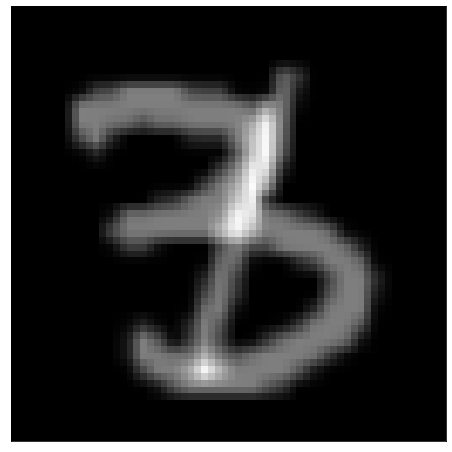

In [0]:
#make our Frankenstein true image
img_true = next(iter(train_loader))
img_true = (img_true[0][1]+img_true[0][6])/2
print(img_true.shape)
img_true = img_true.view(1,1,64,64)
imshow(img_true)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 64, 64])


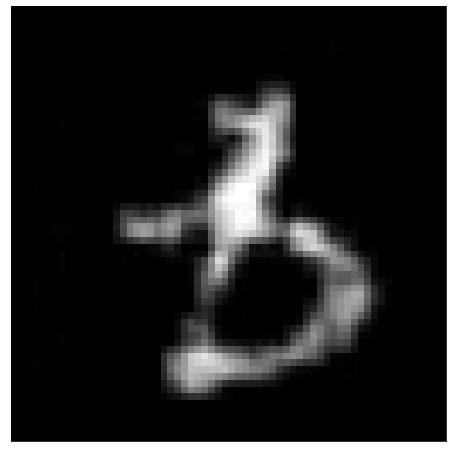

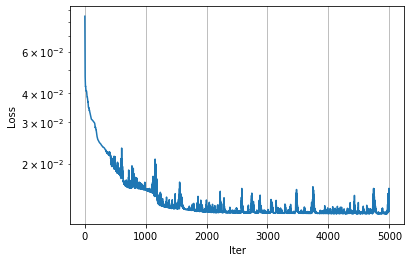

In [0]:
losses_1 = []
img_true = Variable(img_true.cuda())
for epoch in range(5):
    for i in range(1000):
       
        opt_model.zero_grad()
        

        preds = opt_model()

        preds = preds.view(-1,32,1,1)
        G_pred = G(preds)

        loss_value = loss(G_pred, img_true)

        loss_value.backward()
        optimizer.step()

        losses_1.append(loss_value.item())

    
    clear_output()
    print(G_pred.shape)
    G_res = G(preds)
    sample = G_res.detach()

    imshow(sample)
    plt.xlabel("Iter")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.semilogy(losses_1)
    plt.show()

*Видим, что вполне неплохо восстанавливает и слепленное изображение.
А справится ли с этим feed-forward model?*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


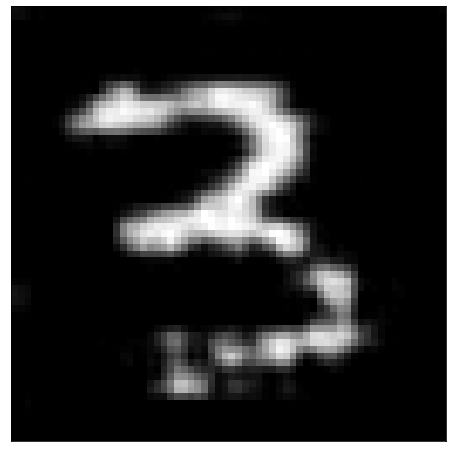

In [0]:
img_true = img_true.view(-1, 1, 64, 64)
a = model.forward(img_true)
a= a.view(-1,32,1,1)
G_res = G(a)
sample = G_res.detach()
imshow(sample)
plt.show()

Видим, что эта модель так же справляется с этим заданием, но более сглаженно, оставляет меньше деталей.


На этом все, спасибо за внимание))


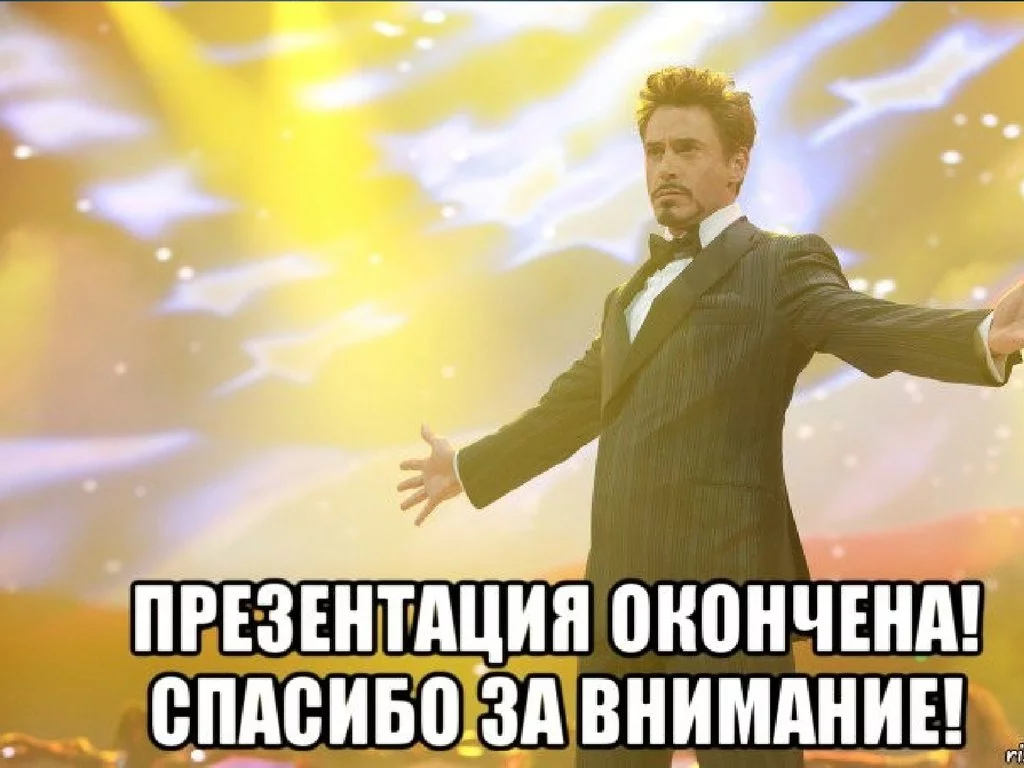